# House Prices
### This notebook creates a predictive model for determining the sale price of homes in Ames, Iowa.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Import and explore dataset

In [177]:
train = pd.read_csv("train_homes.csv")
test = pd.read_csv("test_homes.csv")

In [178]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [4]:
# viewing the data type for each attribute
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Cleaning the data

Combine the train and test datasets for cleaning. Save the target variable.

In [179]:
y = train['SalePrice']
data = pd.concat([train, test], ignore_index=True, sort=False)
data.drop('SalePrice', axis=1, inplace=True)
data.shape

(2919, 80)

Drop the ID column as it provides no information

In [180]:
data.drop('Id', axis=1, inplace=True)

In [181]:
y

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

### Handle missing values

In [8]:
pd.set_option('display.max_rows', None)
data.isnull().sum()

MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
MasVnrArea         23
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinSF1          1
BsmtFinType2       80
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea 

Check for percentages and drop any column with greater than 50% missing values

In [9]:
data.isnull().sum()/len(data) * 100

MSSubClass        0.000000
MSZoning          0.137033
LotFrontage      16.649538
LotArea           0.000000
Street            0.000000
Alley            93.216855
LotShape          0.000000
LandContour       0.000000
Utilities         0.068517
LotConfig         0.000000
LandSlope         0.000000
Neighborhood      0.000000
Condition1        0.000000
Condition2        0.000000
BldgType          0.000000
HouseStyle        0.000000
OverallQual       0.000000
OverallCond       0.000000
YearBuilt         0.000000
YearRemodAdd      0.000000
RoofStyle         0.000000
RoofMatl          0.000000
Exterior1st       0.034258
Exterior2nd       0.034258
MasVnrType        0.822199
MasVnrArea        0.787941
ExterQual         0.000000
ExterCond         0.000000
Foundation        0.000000
BsmtQual          2.774923
BsmtCond          2.809181
BsmtExposure      2.809181
BsmtFinType1      2.706406
BsmtFinSF1        0.034258
BsmtFinType2      2.740665
BsmtFinSF2        0.034258
BsmtUnfSF         0.034258
T

In [10]:
pd.reset_option('display.max_rows')

Capturing the variables that don't meet the missing value threshold

In [182]:
a = data.isnull().sum()/len(data) * 100

variables = data.columns
null_variables = []

for i in range(0, len(data.columns)):
    if a[i] >= 50:
        null_variables.append(variables[i])

In [183]:
null_variables

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [184]:
data.drop(null_variables, axis=1, inplace=True)

FireplaceQu had 48% of it's values missing which didn't meet the threshold. We can assume that if there's no value then the home doesn't have a fireplace so we will fill the missing values with 'NA'. Using NA throughout in case there's already records containing NA.

In [185]:
data['FireplaceQu'] = data['FireplaceQu'].fillna('NA')

In [186]:
# sanity check, dropped 5 columns thus far, total should be 75
len(data.columns)

75

Remaining variables with missing data

In [16]:
print(data.columns[data.isnull().any()])
print(len(data.columns[data.isnull().any()]))

Index(['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath',
       'KitchenQual', 'Functional', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'SaleType'],
      dtype='object')
29


Checking on variable type for the remainder of the missing values because that will help decide what type of imputation to use

In [17]:
data[data.columns[data.isnull().any()]].dtypes

MSZoning         object
LotFrontage     float64
Utilities        object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinSF1      float64
BsmtFinType2     object
BsmtFinSF2      float64
BsmtUnfSF       float64
TotalBsmtSF     float64
Electrical       object
BsmtFullBath    float64
BsmtHalfBath    float64
KitchenQual      object
Functional       object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageCars      float64
GarageArea      float64
GarageQual       object
GarageCond       object
SaleType         object
dtype: object

### Imputation

Of the missing features a bunch are related to either the basement or garage. Based on the data descriptions several of the other non-numerical variables can be imputed with the most common value becuase, for example, every house has an exterior, electricity, kitchen, etc.

In [187]:
for col in ('MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'Electrical', 'KitchenQual', 'Functional', 'SaleType'):
    data[col] = data[col].fillna(data[col].mode()[0])

##### LotFrontage

Let's explore this variable with a histogram

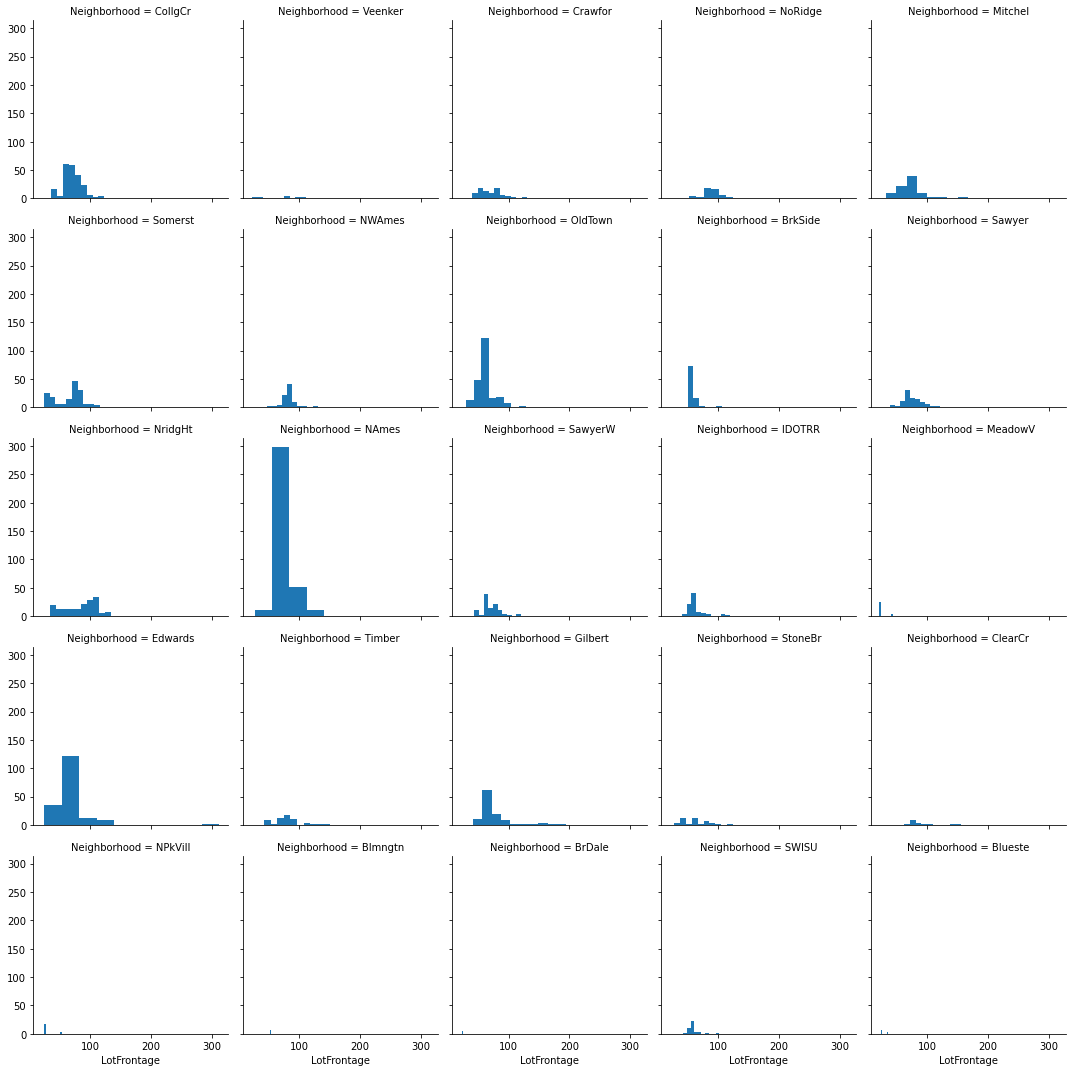

In [19]:
g = sns.FacetGrid(data, col='Neighborhood', col_wrap=5)
g.map(plt.hist, 'LotFrontage')

Based on the distributions above, I will impute the LotFrontage with the median based on the neighborhood.

In [188]:
data['LotFrontage'].fillna(data.groupby('Neighborhood')['LotFrontage'].transform('mean'), inplace=True)

##### Basement Variables

BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2 should be encoded to NA per the data description when no basement exists. 79-82 values are missing for each feature. They do not exactly match but this should be a good enough approximation.

In [189]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[col] = data[col].fillna("NA")

I went through BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF and found they are all the same record 2120. The BsmtFullBath and BsmtHalfBath are also record 2120 but include one extra record 2188 which is also an NA for basement. All the remaining (numeric) basement variables will have 0 imputed for the missing value.

In [190]:
data[data['BsmtFinSF1'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2120,20,RM,99.0,5940,Pave,IR1,Lvl,AllPub,FR3,Gtl,...,0,0,0,0,0,0,4,2008,ConLD,Abnorml


In [23]:
data[data['BsmtQual']=='NA']

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
17,90,RL,72.0,10791,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,500,10,2006,WD,Normal
39,90,RL,65.0,6040,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,6,2008,WD,AdjLand
90,20,RL,60.0,7200,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,29,0,0,0,0,0,7,2006,WD,Normal
102,90,RL,64.0,7018,Pave,Reg,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,0,6,2009,WD,Alloca
156,20,RL,60.0,7200,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,6,2006,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2803,20,RL,100.0,21370,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,225,0,0,0,600,6,2006,WD,Normal
2804,30,RL,55.0,8250,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,121,0,0,0,0,6,2006,WD,Normal
2824,20,RL,80.0,12048,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,189,36,0,348,0,0,4,2006,WD,Normal
2891,30,C (all),69.0,12366,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,23,0,0,0,0,10,2006,WD,Abnorml


In [191]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    data[col] = data[col].fillna(0)

##### Garage and Masonry Veneer Variables

The same approach will be taken with the garage and masonry variables as the basement variables

In [192]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'MasVnrType'):
    data[col] = data[col].fillna('NA')

In [193]:
for col in ('GarageYrBlt', 'GarageCars', 'GarageArea', 'MasVnrArea'):
    data[col] = data[col].fillna(0)

### High Correlation Filter

We will examine the correlation between variables and drop any whose coeffficient is greater than 0.80

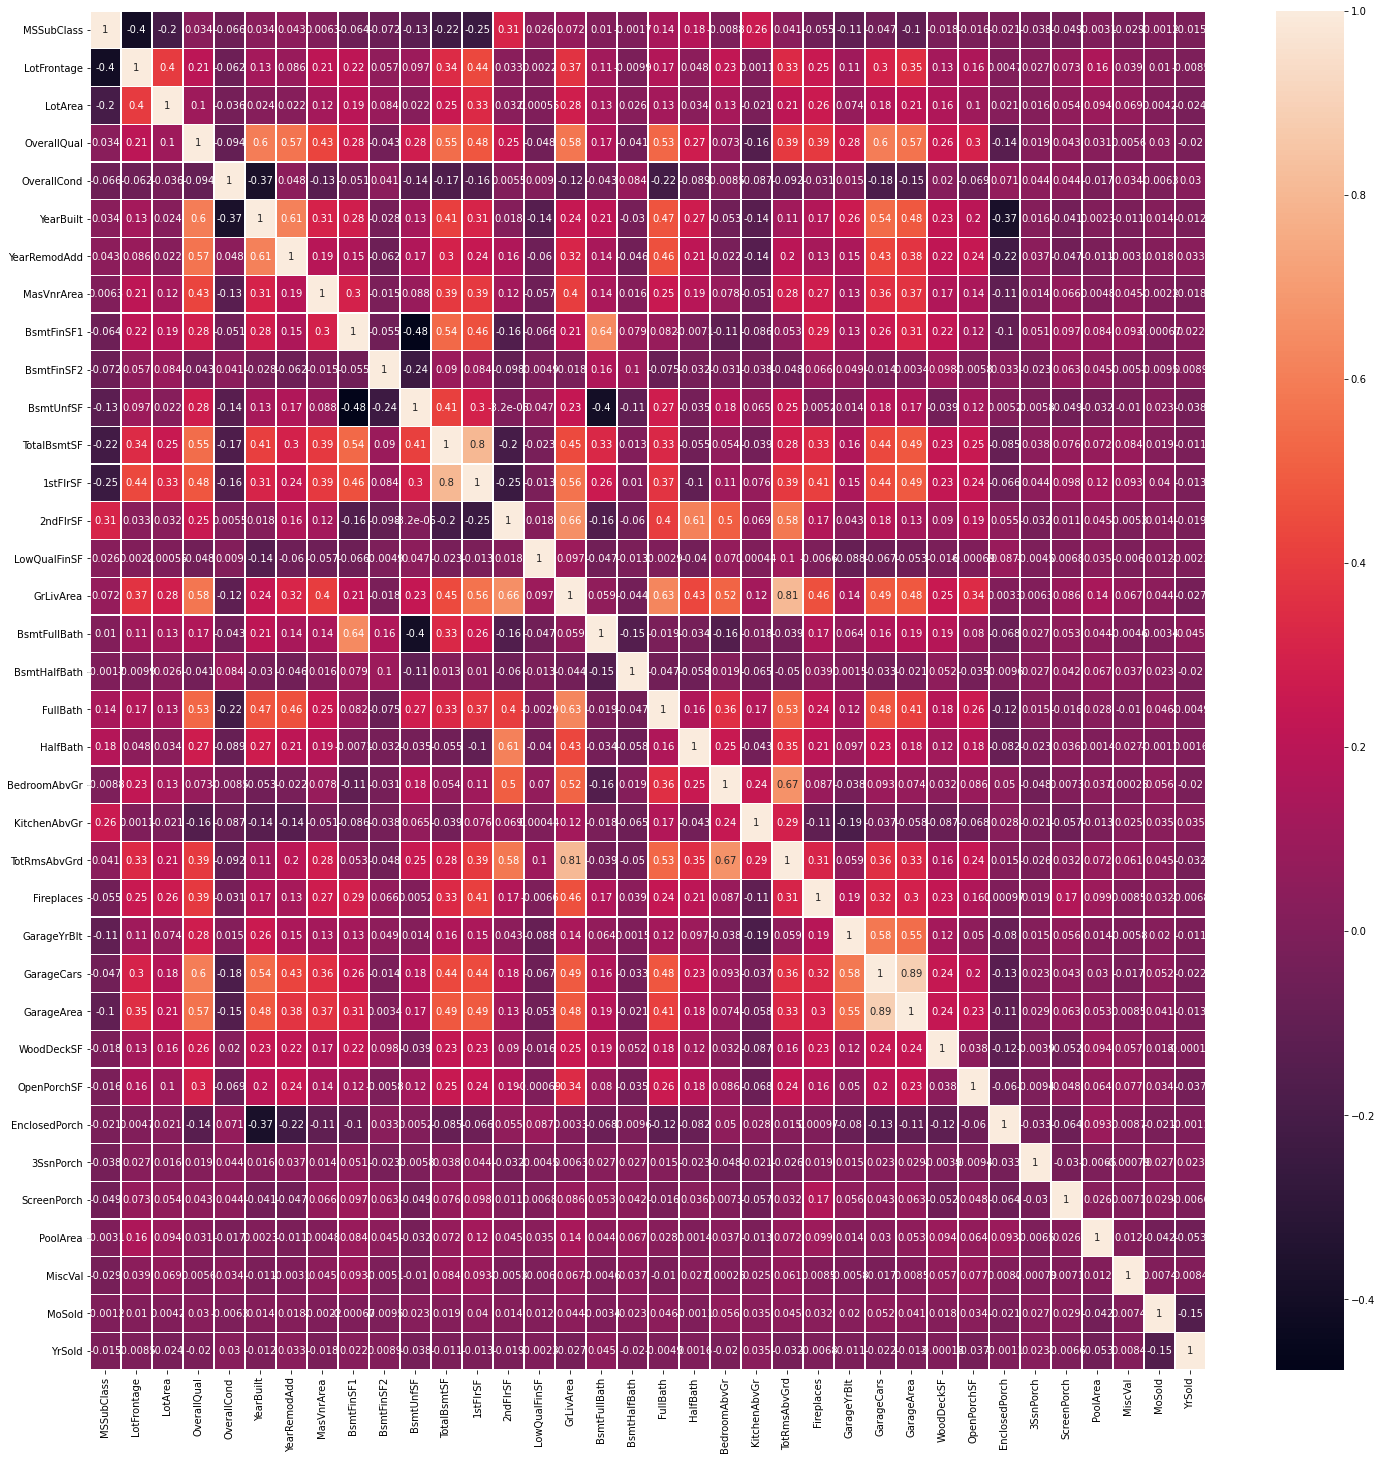

In [27]:
plt.figure(figsize=(25,25))
sns.heatmap(data.corr(), annot=True, linewidths=0.25)

In [28]:
corr = data.corr().abs().unstack()
top_cor = corr[corr>=0.8]
top_cor.sort_values(ascending=False)

YrSold         YrSold           1.000000
BsmtFinSF2     BsmtFinSF2       1.000000
BsmtFullBath   BsmtFullBath     1.000000
GrLivArea      GrLivArea        1.000000
LowQualFinSF   LowQualFinSF     1.000000
2ndFlrSF       2ndFlrSF         1.000000
1stFlrSF       1stFlrSF         1.000000
TotalBsmtSF    TotalBsmtSF      1.000000
BsmtUnfSF      BsmtUnfSF        1.000000
BsmtFinSF1     BsmtFinSF1       1.000000
FullBath       FullBath         1.000000
MasVnrArea     MasVnrArea       1.000000
YearRemodAdd   YearRemodAdd     1.000000
YearBuilt      YearBuilt        1.000000
OverallCond    OverallCond      1.000000
OverallQual    OverallQual      1.000000
LotArea        LotArea          1.000000
LotFrontage    LotFrontage      1.000000
MoSold         MoSold           1.000000
BsmtHalfBath   BsmtHalfBath     1.000000
HalfBath       HalfBath         1.000000
BedroomAbvGr   BedroomAbvGr     1.000000
MiscVal        MiscVal          1.000000
PoolArea       PoolArea         1.000000
ScreenPorch    S

Correlation analysis revels 3 variables to be dropped due to high correlation. Going to keep the numerical variables due to fidelity. For example, GarageCars is the size in car capacity. That is subjective because we don't know what type of car is used to size. Going to keep 1stFlrSF over TotalBsmtSF due to the numerous other variables that characterize the basement.

In [194]:
high_corr = ['GarageCars', 'TotRmsAbvGrd', 'TotalBsmtSF']
data.drop(high_corr, axis=1, inplace=True)

In [195]:
# correct number of expected features, 75-3 = 72
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal


Confirm there are no more missing values

In [196]:
data.isnull().sum().sum()

0

## Feature Engineering

Before converting categorical variables using one-hot encoding or label encoding, let's explore the current numerical variables and see if any can be combined based on intuition.

In [33]:
numeric = data.select_dtypes(['int64', 'float64']).columns
numeric

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'Fireplaces', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

##### year built and year remodeled

The following value counts revealed that one of the records has a remodel date prior to the original construction date which can not be possible.

In [197]:
data['buildDelta'] = data['YearRemodAdd'] - data['YearBuilt']
data['buildDelta'].value_counts()

 0      1560
 1       433
 30       38
 40       32
 25       27
        ... 
 107       1
 109       1
 115       1
 121       1
-1         1
Name: buildDelta, Length: 117, dtype: int64

The histogram shows that the majority of homes were never remodeled. 

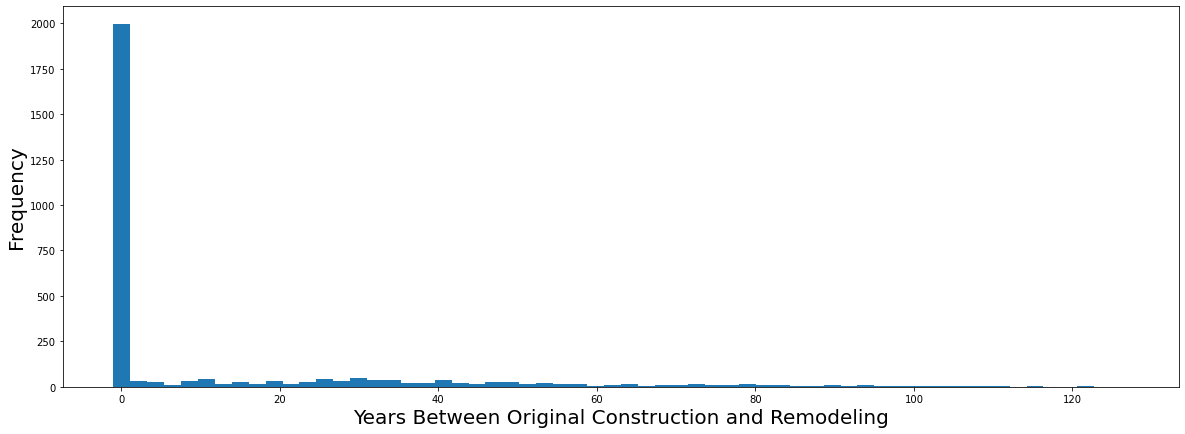

In [198]:
plt.figure(figsize=(20,7))
plt.hist(data['buildDelta'], bins=60)
plt.xlabel('Years Between Original Construction and Remodeling', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.show()

Fix the record with the impossible remodel date. Hard to say which value is incorrect but the 1 year shouldn't make a big difference in the model but a negative value could.

In [199]:
data.loc[data['buildDelta'] == -1]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,buildDelta
1876,20,RL,65.0,10739,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,4,2009,WD,Normal,-1


In [200]:
data['YearRemodAdd'].iloc[1876]

2001

In [201]:
data['YearBuilt'].iloc[1876]

2002

In [202]:
data.at[1876, 'YearRemodAdd'] = 2002
data['YearRemodAdd'].iloc[1876]

2002

Undecided on what to do with the YearBuilt and YearRemodAdd variables. My plan is to use Random Forest later to select feature importance and maybe that will shed light on how to handle these 2 variables.

##### total house size

There are a multitude of measurements for specific areas of the homes. I choose to leave the garage, porch (so many different types), and deck areas alone. Thought about combining the BsmtFinSF1 & 2 but then realized that could skew the value because a bigger number could be percieved as better but it diminishes the quality variable. A smaller finished space could be equal or more desirable than a larger low quality or unfinished space.

However the total home size can be calculated by adding the basement, 1st floor, and 2nd floor square footage. A quick Google search revealed that basements even when finished are not counted per the ANSI standards.

In [203]:
data['TotalHomeSF'] = data['1stFlrSF'] + data['2ndFlrSF']

See if the GrLivArea (above ground living area sqft) is equal to the created TotalHomeSF variable

Text(0.5, 0.98, 'Comparison of Total and Above Ground Home Area')

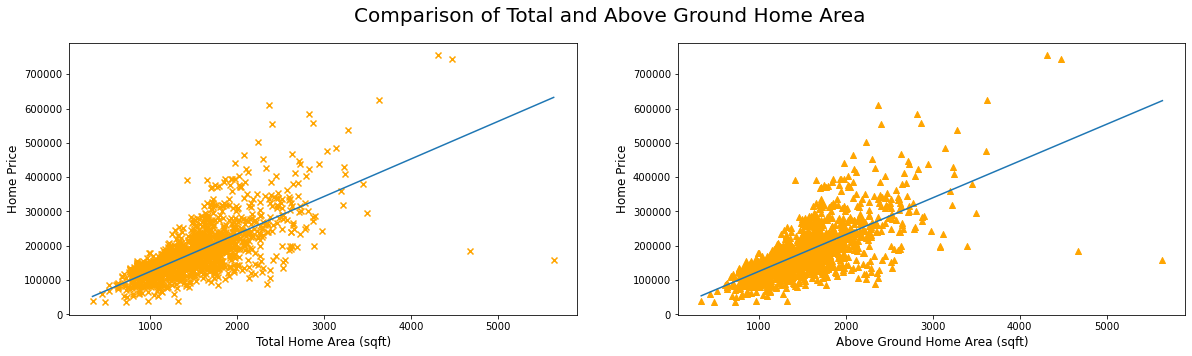

In [205]:
plt.figure(figsize=(20,5))
x0=data['TotalHomeSF'].loc[:1459]
x1=data['GrLivArea'].loc[:1459]


plt.subplot(1,2,1)
plt.scatter(x0, y, c='orange', marker='x')
plt.xlabel('Total Home Area (sqft)', fontsize=12)
plt.ylabel("Home Price", fontsize=12)
plt.plot(np.unique(x0), np.poly1d(np.polyfit(x0, y, 1))(np.unique(x0)))

plt.subplot(1,2,2)
plt.scatter(x1, y, c='orange', marker='^')
plt.xlabel('Above Ground Home Area (sqft)', fontsize=12)
plt.ylabel("Home Price", fontsize=12)
plt.plot(np.unique(x1), np.poly1d(np.polyfit(x1, y, 1))(np.unique(x1)))


plt.subplots_adjust(wspace=0.2)
plt.suptitle("Comparison of Total and Above Ground Home Area", fontsize=20)

The above plots look almost identical. Let calculate the differance between the two variables.

In [206]:
data['HomeAreaDelta'] = data['GrLivArea'] - data['TotalHomeSF']

In [40]:
data['HomeAreaDelta'].value_counts()

0       2879
80         4
205        2
360        2
390        1
384        1
362        1
312        1
234        1
232        1
420        1
156        1
144        1
140        1
120        1
114        1
108        1
392        1
697        1
515        1
371        1
513        1
481        1
479        1
473        1
431        1
397        1
259        1
450        1
53         1
1064       1
572        1
528        1
514        1
512        1
436        1
Name: HomeAreaDelta, dtype: int64

None of the values are negative. I figured based on the graphs there were some values in GrLiveArea that were greater than the created TotalHomeSF. HomeAreaDelta confirmed this intuition.

My thought is to drop the 1st and 2nd floor sqft features as I believe the above ground living area variable accounts for that information. Let's plot to confirm.

Text(0.5, 0.98, 'Comparision of 1st and 2nd Floor Size')

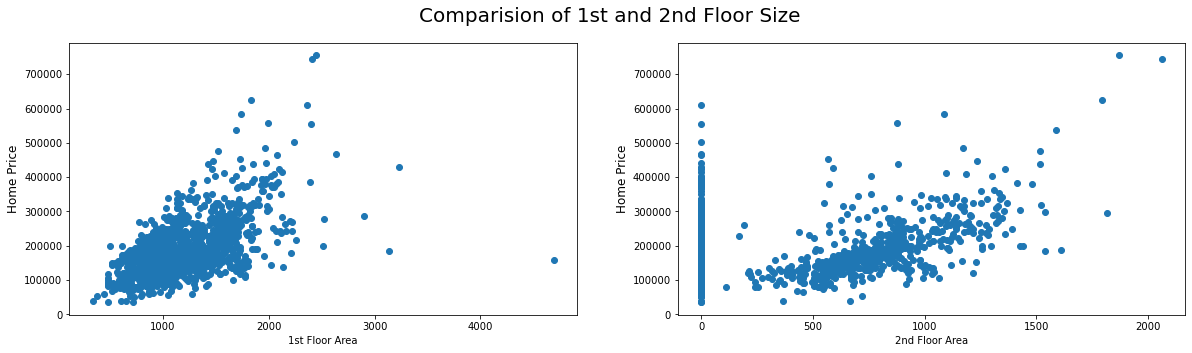

In [208]:
plt.figure(figsize=(20,5))
x0 = data['1stFlrSF'].loc[:1459]
x1 = data['2ndFlrSF'].loc[:1459]

plt.subplot(1,2,1)
plt.scatter(x0, y)
plt.xlabel("1st Floor Area")
plt.ylabel("Home Price", fontsize=12)

plt.subplot(1,2,2)
plt.scatter(x1, y)
plt.xlabel("2nd Floor Area")
plt.ylabel("Home Price", fontsize=12)

plt.subplots_adjust(wspace=0.2)
plt.suptitle("Comparision of 1st and 2nd Floor Size", fontsize=20)

The trend, as expected, is for home value to increase as size of each floor increases. It is apparent that first floor size has a greater impact as it's size increases compared to the 2nd floor. That makes sense given the first floor is the 'living area' and the 2nd floor is largely just bedrooms.

I've concluded the 1st and 2nd floor variables are mostly accounted for by the above ground area. Both features will be dropped along with the created TotalHomeSF and HomeAreaDelta as they are not needed anymore.

In [209]:
size_drops = ['1stFlrSF', '2ndFlrSF', 'TotalHomeSF','HomeAreaDelta']
data.drop(size_drops, axis=1, inplace=True)

##### total bathrooms

Create two variables, total home bathrooms, total basement bathrooms. Drop the individual variables.

In [210]:
data['TotGrBath'] = data['FullBath'] + data['HalfBath']
data.drop(['FullBath', 'HalfBath'], axis=1, inplace=True)

In [211]:
data['TotBsmtBath'] = data['BsmtFullBath'] + data['BsmtHalfBath']
data.drop(['BsmtFullBath', 'BsmtHalfBath'], axis=1, inplace=True)

Using info I saw the TotBsmtBath dtype was float so, checking to make sure there's no weird values like .2 bathrooms. Will change it to an integer.

In [212]:
data['TotBsmtBath'].unique()

array([1., 0., 2., 3.])

In [213]:
data['TotBsmtBath'] = data['TotBsmtBath'].astype('int64')

##### date sold

I think the month variable gives important about home price especially for homes that sold for alot. Lots of outliers in the spring and summer months.

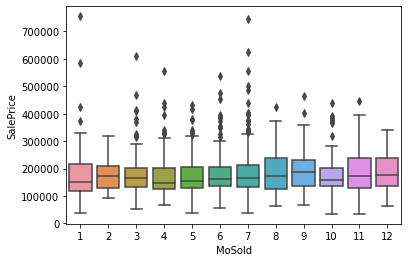

In [47]:
sns.boxplot(x=data['MoSold'], y=y, data=data)

Home prices are a bit more stable year to year.

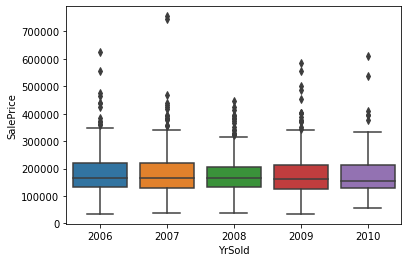

In [48]:
sns.boxplot(x=data['YrSold'], y=y, data=data)

##### label encoding

Some of the categorical features use a likert scale for their values. Instead of using one-hot encoding which creates an extra feature for each value, I'll simply use a dictionary to explictly convert the lables to numbers.

In [214]:
likert = {"ExterQual" : {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
           "ExterCond" : {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
           "BsmtQual" : {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
           "BsmtCond" : {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
           "HeatingQC" : {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
           "KitchenQual" : {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
           "FireplaceQu" : {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
           "GarageQual" : {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
           "GarageCond" : {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
           "CentralAir" : {'Y': 1, 'N': 0}
          }

In [215]:
data.replace(likert, inplace=True)

In [216]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 69 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2919 non-null   object 
 2   LotFrontage    2919 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   LotShape       2919 non-null   object 
 6   LandContour    2919 non-null   object 
 7   Utilities      2919 non-null   object 
 8   LotConfig      2919 non-null   object 
 9   LandSlope      2919 non-null   object 
 10  Neighborhood   2919 non-null   object 
 11  Condition1     2919 non-null   object 
 12  Condition2     2919 non-null   object 
 13  BldgType       2919 non-null   object 
 14  HouseStyle     2919 non-null   object 
 15  OverallQual    2919 non-null   int64  
 16  OverallCond    2919 non-null   int64  
 17  YearBuilt      2919 non-null   int64  
 18  YearRemo

## Feature Selection

Use random forest to identify the most important features. First all variables must be numerical. One hot encoding will be used to convert categorical variables. The first dummy variable will be dropped after conversion because it can be inferred from the other variables.

In [217]:
data = pd.concat([data, pd.get_dummies(data.select_dtypes(include=['object']), drop_first=True)], axis=1)

In [218]:
data.drop(data.select_dtypes(include='object').columns, axis=1, inplace=True)

In [219]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Columns: 213 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(7), int64(33), uint8(173)
memory usage: 1.4 MB


Random Forest Model

In [220]:
model_RF = RandomForestRegressor(random_state=3, max_depth=15)
model_RF.fit(data.iloc[:len(train), :], y)

RandomForestRegressor(max_depth=15, random_state=3)

In [221]:
features = data.columns
importances = model_RF.feature_importances_

Selecting top features 

In [222]:
indices = np.argsort(importances)[-25:]

Plot the top features

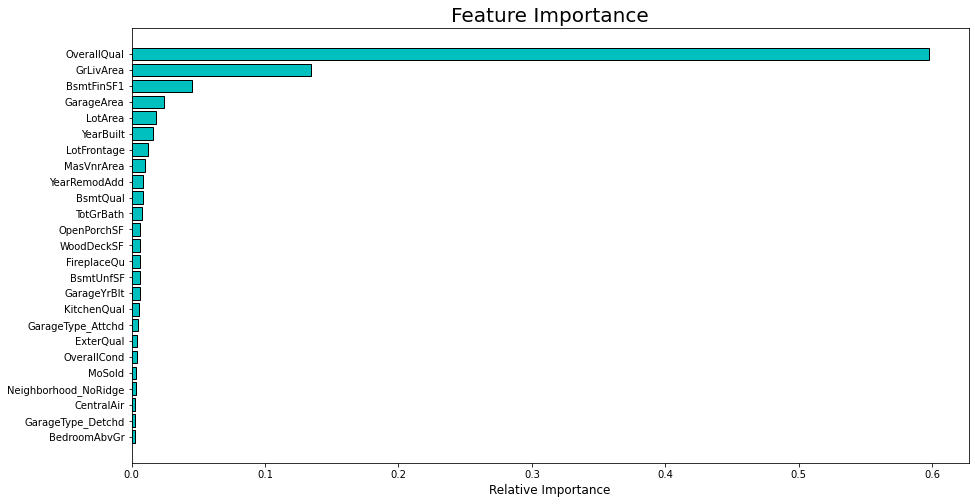

In [223]:
plt.figure(figsize=(15,8))
plt.barh(range(len(indices)), importances[indices], color='c', align='center', edgecolor='k')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance', fontsize=12)
plt.title('Feature Importance', fontsize=20)
plt.show()

I wasn't sure how to handle the YearBuilt and YearRemodAdd variables but seeing that the both are individually important in predicting the home price I am going to leave them unmodified. That pleases me!

So I'm going to select the top 15 features and subset the dataframe for training

In [224]:
f = [features[i] for i in indices]
f.reverse()
model_features = f[:15]
model_features

['OverallQual',
 'GrLivArea',
 'BsmtFinSF1',
 'GarageArea',
 'LotArea',
 'YearBuilt',
 'LotFrontage',
 'MasVnrArea',
 'YearRemodAdd',
 'BsmtQual',
 'TotGrBath',
 'OpenPorchSF',
 'WoodDeckSF',
 'FireplaceQu',
 'BsmtUnfSF']

In [225]:
topFeaturesData = data[model_features]

In [226]:
topFeaturesData

,OverallQual,GrLivArea,BsmtFinSF1,GarageArea,LotArea,YearBuilt,LotFrontage,MasVnrArea,YearRemodAdd,BsmtQual,TotGrBath,OpenPorchSF,WoodDeckSF,FireplaceQu,BsmtUnfSF
0,7,1710,706.0,548.0,8450,2003,65.0,196.0,2003,4,3,61,0,0,150.0
1,6,1262,978.0,460.0,9600,1976,80.0,0.0,1976,4,2,0,298,3,284.0
2,7,1786,486.0,608.0,11250,2001,68.0,162.0,2002,4,3,42,0,3,434.0
3,7,1717,216.0,642.0,9550,1915,60.0,0.0,1970,3,1,35,0,4,540.0
4,8,2198,655.0,836.0,14260,2000,84.0,350.0,2000,4,3,84,192,3,490.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,4,1092,0.0,0.0,1936,1970,21.0,0.0,1970,3,2,0,0,0,546.0
2915,4,1092,252.0,286.0,1894,1970,21.0,0.0,1970,3,2,24,0,0,294.0
2916,5,1224,1224.0,576.0,20000,1960,160.0,0.0,1996,3,1,0,474,3,0.0
2917,5,970,337.0,0.0,10441,1992,62.0,0.0,1992,4,1,32,80,0,575.0


## Modeling

#### Split data

Split the data back into train and test sets using the topFeaturesData. The target variable (y) was saved earlier.

In [227]:
X = topFeaturesData.iloc[:len(train),:]
test = topFeaturesData.iloc[len(train):,:]

In [228]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=90)

#### Normalize data

My reading has indicated both the training and test data should be normalized

In [125]:
scaler = MinMaxScaler()

In [143]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
test = scaler.fit_transform(test)
X_train.shape[1]

15

#### Build Model

In [268]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score

In [233]:
model = Sequential()

#input layer
model.add(Dense(X_train.shape[1], kernel_initializer='normal', activation='relu'))

#hidden layers
model.add(Dense(25, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='linear'))

#using the mean squared error for loss because its a regression problem
model.compile(optimizer='adam', loss='mean_squared_error')

In [234]:
model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), batch_size=16, epochs=10)

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

73/73 [==============================] - 0s 2ms/step - loss: 39525502976.0000 - val_loss: 36169060352.0000
Epoch 2/10
73/73 [==============================] - 0s 2ms/step - loss: 33865029632.0000 - val_loss: 22162477056.0000
Epoch 3/10
73/73 [==============================] - 0s 2ms/step - loss: 13719755776.0000 - val_loss: 5717217792.0000
Epoch 4/10
73/73 [==============================] - 0s 2ms/step - loss: 9776912384.0000 - val_loss: 5087707136.0000
Epoch 5/10
73/73 [=====================

#### Evaluate Model

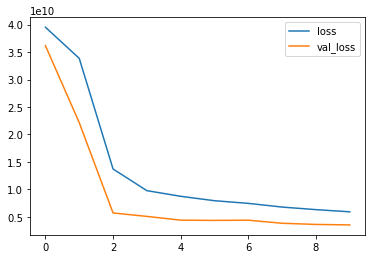

In [235]:
history = pd.DataFrame(model.history.history)
history[['loss', 'val_loss']].plot()

##### RMSE and R2

In [267]:
predictions = model.predict(X_test)

In [273]:
from math import sqrt
print("Root Mean Square Error:", sqrt(mean_squared_error(y_test, predictions)))

Root Mean Square Error: 59489.464034454155


In [271]:
print("R2 score:",r2_score(y_test, predictions))

R2 score: 0.35830418232814676


Text(0.5, 1.0, 'Actual vs Predicted Home Price')

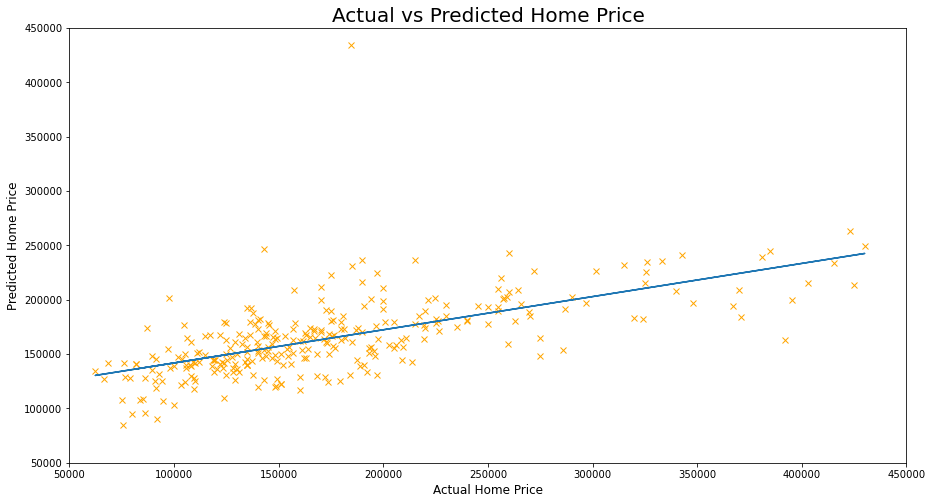

In [279]:
plt.figure(figsize=(15,8))
x = y_test
y = predictions.T[0]
plt.plot(x, y, 'x', color='orange')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b )

plt.ylim(50000,450000)
plt.xlim(50000,450000)

plt.xlabel("Actual Home Price", fontsize=12)
plt.ylabel("Predicted Home Price", fontsize=12)
plt.title('Actual vs Predicted Home Price', fontsize=20)

## Making predictions on test data and creating submission file for Kaggle

In [251]:
final_predictions = model.predict(test)
final_predictions=final_predictions.T[0]

In [253]:
submission = pd.DataFrame(data= {'Id': range(1461,2920), 'SalePrice': final_predictions})
submission.to_csv('house_prices_kaggle.csv', index=False)